In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Nivell 1
#### Exercici 1
Crea almenys tres models de classificació diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv.

Vamos a crear tres modelos con sendos algoritmos:
- Regresión logística, usando Lasso
- knn
- XGBoost

In [2]:
#Leemos el dataset de las aerolíneas
df=pd.read_csv('Desktop/DataScience/datasets/DelayedFlights/DelayedFlights.csv')
df.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


#### Exercici 2,3,4
Crea una nova variable segons si el vol ha arribat tard o no (ArrDelay > 0).

Compara els models de classificació utilitzant la precisió (accuracy), una matriu de confiança i d’altres mètriques més avançades.

Entrena’ls utilitzant els diferents paràmetres que admeten.

In [3]:
# Creamos la feature retraso, 1 si llega tarde y 0 si no
df['Retraso']=df.ArrDelay.apply(lambda x: 1 if x>0 else 0)
df[['ArrDelay','Retraso']].head() #comparamos las dos columnas y los datos concuerdan

,ArrDelay,Retraso
0,-14.0,0
1,2.0,1
2,14.0,1
3,34.0,1
4,11.0,1


Vamos a trabajar inicialmente con las variables numéricas relacionadas con tiempo y distancia, 12 variables que en el caso de la regresión nos dio muy buenos resultados. Si no obtenemos una buena precisión iremos añadiendo otras variables del dataset.

In [4]:
# Sustituimos ArrDelay por retraso
df=df[['DepTime','CRSDepTime','ArrTime','CRSArrTime','ActualElapsedTime','CRSElapsedTime','AirTime','DepDelay','Distance','TaxiIn','TaxiOut','Retraso']]
df_=df.dropna() #Eliminamos nulos

In [5]:
#Vemos que el dataset no es balanceado
print('Valores de Retraso en %:')
np.round(df_.Retraso.value_counts(normalize=True)*100,2)

Valores de Retraso en %:


1    89.37
0    10.63
Name: Retraso, dtype: float64

In [6]:
#Separamos el dataset por variables independientes y variable dependiente
X_=df_.drop(['Retraso'],'columns')
y_=df_.Retraso

In [7]:
# Estandarizamos con RobustScaler, conseguiremos un modelo más robusto contra outliers
X_ = RobustScaler().fit_transform(X_)

In [8]:
X_=pd.DataFrame(X_,columns=df.columns[:-1])
X_.head()

,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,DepDelay,Distance,TaxiIn,TaxiOut
0,0.657102,0.654412,0.694678,0.754717,0.141176,0.409639,0.329114,-0.390244,0.309560,-0.50,-0.545455
1,-1.134864,-1.139706,-0.998599,-1.023222,0.141176,0.349398,0.291139,-0.121951,0.309560,-0.25,-0.363636
2,-1.315638,-1.308824,-1.275910,-1.386067,-0.235294,-0.313253,-0.177215,-0.390244,-0.138088,-0.75,0.272727
3,0.407461,0.360294,0.341737,0.319303,-0.305882,-0.313253,-0.164557,0.243902,-0.138088,-0.75,-0.363636
4,0.566714,0.595588,0.568627,0.587808,-0.176471,-0.012048,-0.037975,0.024390,0.124431,-0.50,-0.363636


In [9]:
# train y test sets (20% test set)
# usamos stratify
X_train,X_test,y_train,y_test=train_test_split(X_,y_,test_size=0.2,random_state=42,stratify=y_)

### Caso 1: Regresión logística

Vamos a utilizar regresión logística con Lasso (L1) para evitar overfitting. Lasso además de reducir los coeficientes para eliminar el overfitting nos dice si hay alguna variable que no es necesaria poniendo su coeficiente a cero.

In [37]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=0.1, penalty='l1', tol=0.01, solver='saga')
logreg.fit(X_train,y_train)

LogisticRegression(C=0.1, penalty='l1', solver='saga', tol=0.01)

In [11]:
y_pred=logreg.predict_proba(X_train)

In [38]:
acc_train=np.round(logreg.score(X_train, y_train),2)
acc_train

0.99

In [39]:
acc_test=np.round(logreg.score(X_test, y_test),2)
acc_test

0.99

No hay overfitting

In [40]:
logreg.coef_[0]

array([ 5.30465419e-02, -2.45170244e-02,  2.44251048e-02, -5.80706860e-02,
        2.04724670e+01, -4.35089122e+01,  2.23329860e+01,  2.20273935e+01,
       -9.46381582e-02,  1.17034248e+00,  3.23888886e+00])

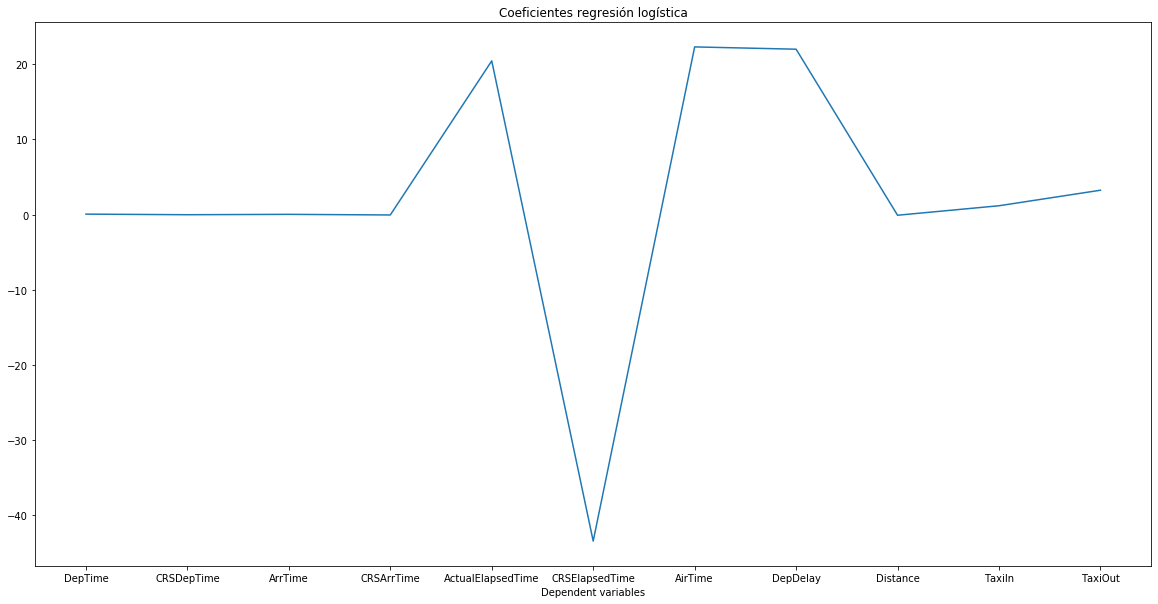

In [41]:
plt.figure(figsize=(20,10))
plt.plot(X_.columns,logreg.coef_[0])
plt.xlabel('Dependent variables')
plt.title('Coeficientes regresión logística')
plt.show()

El gráfico nos muestra qué variables no son necesarias y cuáles sí. Lógicamente coinciden con las variables que obtuvimos en la regresión múltiple del anterior notebook. Vamos a usar estas 6 variables en el resto de algoritmos.

Hemos eliminado los valores con exponente 10 <sup>-2</sup>

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,precision_score,recall_score,roc_auc_score,accuracy_score

In [42]:
# confusion matrix
y_pred=logreg.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

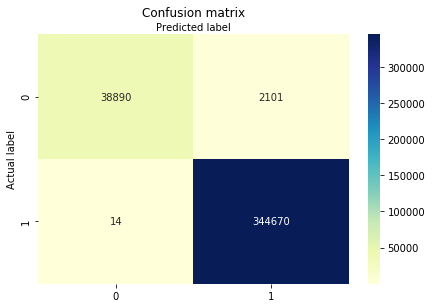

In [43]:
class_names=[0,1] # classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [44]:
#Otras métricas test
precision_test=np.round(precision_score(y_test, y_pred),2)
recall_test=np.round(recall_score(y_test, y_pred),2)
print("Precision Test:",precision_test)
print("Recall Test:",recall_test)

Precision Test: 0.99
Recall Test: 1.0


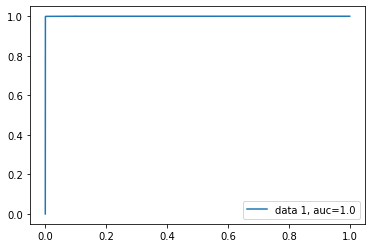

In [47]:
#AUC
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = np.round(roc_auc_score(y_test, y_pred_proba),2)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Tenemos tanto en train como en test una accuracy del 99%. En clasificaciób son también muy importantes métricas como la precisión y la sensibilidad (recall). Ambas son buenísimas, del 99% lo que nos da una AUC perfecta de casi el 100%

In [48]:
# Guardamos métricas
resumen={}
resumen['logistic regression']={'accuracy train':acc_train,'accuracy test':acc_test,'precision test':precision_test,'recall test':recall_test,'auc':auc}

### Caso 2: KNN

Vamos a usar las variables independientes que regresión logística indicó: ActualElapsedTime, CRSElapsedTime, AirTime, DepDelay, TaxiIn y TaxiOut.

Knn observa las n muestras más próximas a la muestra analizada y la clasifica con el valor más repetido en las n muestras.
Aumentamos el valor de k para no tener overfitting

In [49]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
lista=['ActualElapsedTime','CRSElapsedTime','AirTime','DepDelay','TaxiIn','TaxiOut']
knn.fit(X_train[lista], y_train)

KNeighborsClassifier(n_neighbors=10)

In [50]:
#accuracy train
acc_train=np.round(knn.score(X_train[lista], y_train),2)
acc_train

0.98

In [51]:
# confusion matrix
y_pred = knn.predict(X_test[lista])
cnf_matrix = confusion_matrix(y_test, y_pred)

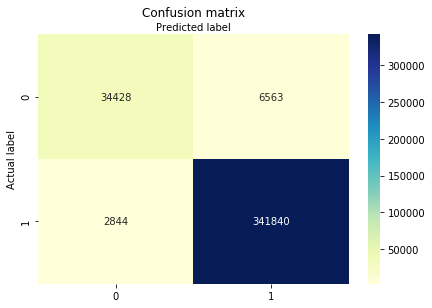

In [52]:
class_names=[0,1] # classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [55]:
# métricas test
acc_test=np.round(accuracy_score(y_test, y_pred),2)
precision_test=np.round(precision_score(y_test, y_pred),2)
recall_test=np.round(recall_score(y_test, y_pred),2)
print("Accuracy Test:",acc_test)
print("Precision Test:",precision_test)
print("Recall Test:",recall_test)

Accuracy Test: 0.98
Precision Test: 0.98
Recall Test: 0.99


No hay overfitting. Las accuracies de train y test son iguales.

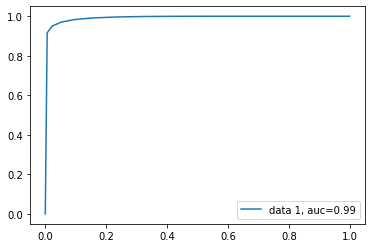

In [56]:
# AUC
y_pred_proba = knn.predict_proba(X_test[lista])[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = np.round(roc_auc_score(y_test, y_pred_proba),2)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Tenemos en test una precisión y sensibilidad (recall) del 98 y 99% respectivamente y una AUC del 99%. Siguen siendo muy buenas aunque un poco peor que las obtenidas con la regresión logística.

In [57]:
# Guardamos métricas
resumen['knn']={'accuracy train':acc_train,'accuracy test':acc_test,'precision test':precision_test,'recall test':recall_test,'auc':auc}

### Caso 3.XGBoost

In [58]:
from xgboost import XGBClassifier

In [59]:
params = {
            'objective':'binary:logistic',
            'max_depth': 5,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':10
        }    

In [60]:
xgb_clf = XGBClassifier(**params)

In [61]:
xgb_clf.fit(X_train[lista], y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1.0, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
y_pred = xgb_clf.predict(X_train[lista])
acc_train=np.round(accuracy_score(y_train, y_pred),2)
acc_train

0.95

In [63]:
y_pred = xgb_clf.predict(X_test[lista])
acc_test=np.round(accuracy_score(y_test, y_pred),2)
acc_test

0.95

In [66]:
# métricas test
precision_test=np.round(precision_score(y_test, y_pred),2)
recall_test=np.round(recall_score(y_test, y_pred),2)
print("Precision Test:",precision_test)
print("Recall Test:",recall_test)

Precision Test: 0.96
Recall Test: 0.98


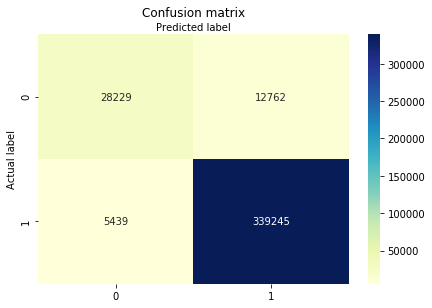

In [67]:
#Confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

class_names=[0,1] # classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

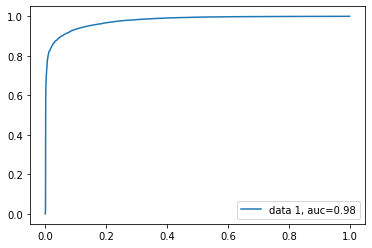

In [68]:
# AUC
y_pred_proba = xgb_clf.predict_proba(X_test[lista])[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = np.round(roc_auc_score(y_test, y_pred_proba),2)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [69]:
# Guardamos métricas
resumen['XGBoost']={'accuracy train':acc_train,'accuracy test':acc_test,'precision test':precision_test,'recall test':recall_test,'auc':auc}

#### Exercici 5
Compara el seu rendiment utilitzant l’aproximació traint/test o utilitzant totes les dades (validació interna).

In [70]:
df_resumen=pd.DataFrame(resumen)
df_resumen

,logistic regression,knn,XGBoost
accuracy train,0.99,0.98,0.95
accuracy test,0.99,0.98,0.95
precision test,0.99,0.98,0.96
recall test,1.00,0.99,0.98
auc,1.00,0.99,0.98


Los tres tienen muy buenos comportamientos. El que mejor resultado da es la regresión logística seguida de XGBoost y Knn. Nos quedaríamos con la primera opción, la regresión logística, por ser la que clasifica mejor y por ser un algortimo sencillo y rápido.

XGBoost también es rápido, en cambio knn, al ser un dataset grande, es penalizado y es más lento que los otros dos algoritmos.

#### Exercici 6


**Realitza algun procés d’enginyeria de variables per millorar-ne la predicció**

He utilizado anteriormente Lasso en la regresión logística que, además de reducir el overfitting, me indica qué variables 
no son necesarias, poniendo sus coeficientes a cero, ya que no aportan información al algoritmo.
Como es lógico son las mismas variables que obteníamos en la regresión múltiple del notebook anterior.

Para knn y XGBoost he usado ya estas 6 variables

#### Exercici 7
No utilitzis la variable DepDelay a l’hora de fer prediccions

In [71]:
# Quitamos la columna de DepDelay del train y test sets
X_train2=X_train.drop(['DepDelay'],axis=1)
X_test2=X_test.drop(['DepDelay'],axis=1)

#### Regresión logística:

In [72]:
logreg2 = LogisticRegression(C=0.1, penalty='l1', tol=0.01, solver='saga')
logreg2.fit(X_train2,y_train)

LogisticRegression(C=0.1, penalty='l1', solver='saga', tol=0.01)

In [73]:
y_pred=logreg2.predict_proba(X_train2)

In [74]:
acc_train=np.round(logreg2.score(X_train2, y_train),2)
acc_train

0.89

In [75]:
acc_test=np.round(logreg2.score(X_test2, y_test),2)
acc_test

0.89

In [76]:
logreg2.coef_[0]

array([  0.7542801 ,  -0.23049081,  -0.41435449,   0.22866535,
         5.51660159, -11.67339933,   5.96381989,  -0.11776804,
         0.42907462,   1.22373785])

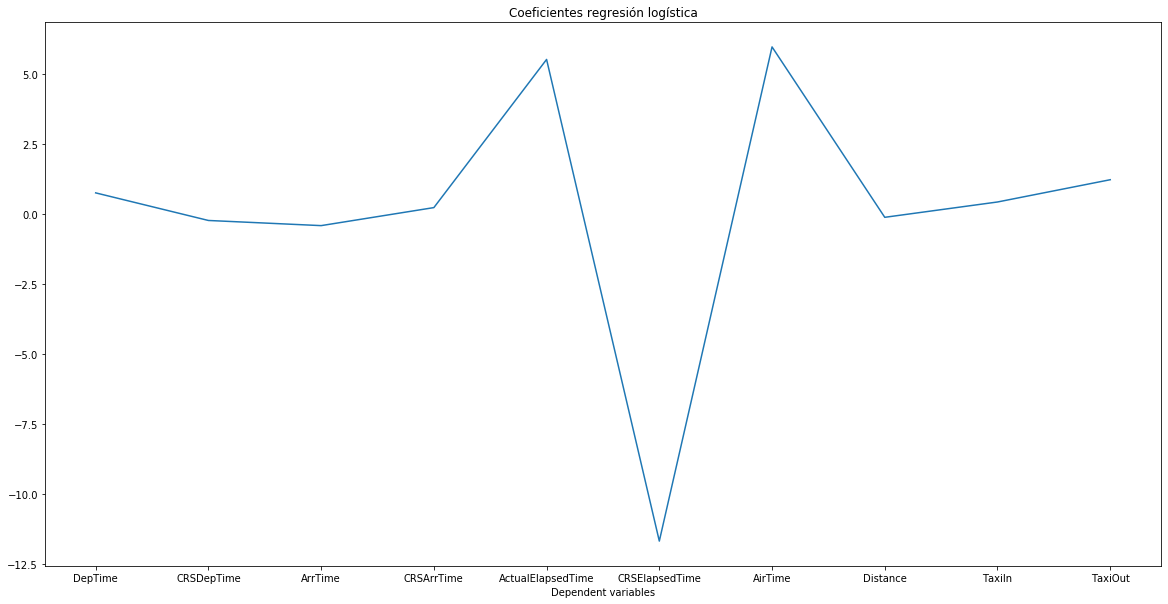

In [77]:
plt.figure(figsize=(20,10))
plt.plot(X_train2.columns,logreg2.coef_[0])
plt.xlabel('Dependent variables')
plt.title('Coeficientes regresión logística')
plt.show()

Ahora al eliminar DepDelay las variables que antes eliminábamos tienen un poco más de importancia, no tienen valores muy grandes pero ya no están en el nivel de las centésimas

In [79]:
# confusion matrix
y_pred=logreg2.predict(X_test2)
cnf_matrix = confusion_matrix(y_test, y_pred)

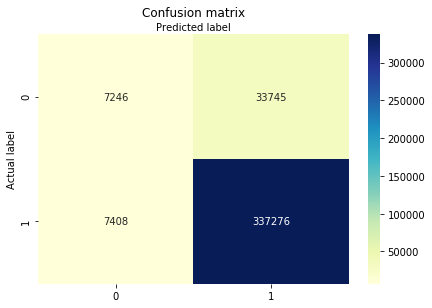

In [80]:
class_names=[0,1] # classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [81]:
#Otras métricas test
precision_test=np.round(precision_score(y_test, y_pred),2)
recall_test=np.round(recall_score(y_test, y_pred),2)
print("Precision Test:",precision_test)
print("Recall Test:",recall_test)

Precision Test: 0.91
Recall Test: 0.98


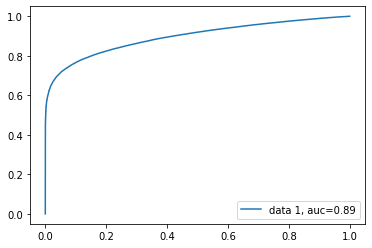

In [82]:
# AUC
y_pred_proba = logreg2.predict_proba(X_test2)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = np.round(roc_auc_score(y_test, y_pred_proba),2)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [83]:
# Guardamos métricas
resumen2={}
resumen2['logistic regression']={'accuracy train':acc_train,'accuracy test':acc_test,'precision test':precision_test,'recall test':recall_test,'auc':auc}

#### KNN:

In [84]:
knn2 = KNeighborsClassifier(n_neighbors=10)
knn2.fit(X_train2, y_train)

KNeighborsClassifier(n_neighbors=10)

In [85]:
#accuracy train
acc_train=np.round(knn2.score(X_train2, y_train),2)
acc_train

0.92

In [86]:
# confusion matrix
y_pred = knn2.predict(X_test2)
cnf_matrix = confusion_matrix(y_test, y_pred)

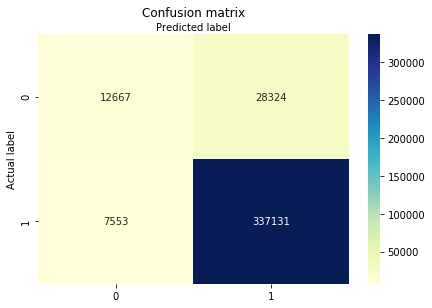

In [87]:
class_names=[0,1] # classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [88]:
# métricas test
acc_test=np.round(accuracy_score(y_test, y_pred),2)
precision_test=np.round(precision_score(y_test, y_pred),2)
recall_test=np.round(recall_score(y_test, y_pred),2)
print("Accuracy Test:",acc_test)
print("Precision Test:",precision_test)
print("Recall Test:",recall_test)

Accuracy Test: 0.91
Precision Test: 0.92
Recall Test: 0.98


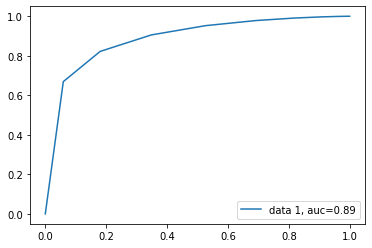

In [89]:
#AUC
y_pred_proba = knn2.predict_proba(X_test2)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = np.round(roc_auc_score(y_test, y_pred_proba),2)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [90]:
# Guardamos métricas
resumen2['knn']={'accuracy train':acc_train,'accuracy test':acc_test,'precision test':precision_test,'recall test':recall_test,'auc':auc}

#### XGBoost:

In [91]:
params = {
            'objective':'binary:logistic',
            'max_depth': 5,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':10
        }    

In [92]:
xgb_clf2 = XGBClassifier(**params)

In [93]:
xgb_clf2.fit(X_train2, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1.0, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [94]:
y_pred = xgb_clf2.predict(X_train2)
acc_train=np.round(accuracy_score(y_train, y_pred),2)
acc_train

0.93

In [95]:
y_pred = xgb_clf2.predict(X_test2)
acc_test=np.round(accuracy_score(y_test, y_pred),2)
acc_test

0.93

In [96]:
# métricas test
precision_test=np.round(precision_score(y_test, y_pred),2)
recall_test=np.round(recall_score(y_test, y_pred),2)
print("Precision Test:",precision_test)
print("Recall Test:",recall_test)

Precision Test: 0.93
Recall Test: 0.99


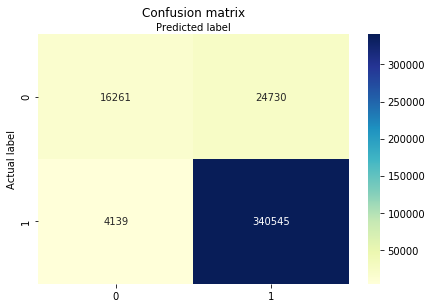

In [97]:
#Confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

class_names=[0,1] # classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

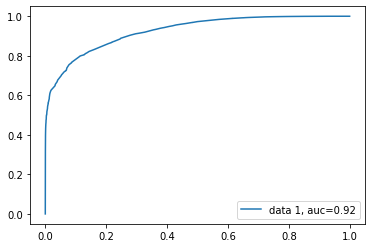

In [98]:
# AUC
y_pred_proba = xgb_clf2.predict_proba(X_test2)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = np.round(roc_auc_score(y_test, y_pred_proba),2)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [99]:
# Guardamos métricas
resumen2['XGBoost']={'accuracy train':acc_train,'accuracy test':acc_test,'precision test':precision_test,'recall test':recall_test,'auc':auc}

In [100]:
df_resumen2=pd.DataFrame(resumen2)
df_resumen2

,logistic regression,knn,XGBoost
accuracy train,0.89,0.92,0.93
accuracy test,0.89,0.91,0.93
precision test,0.91,0.92,0.93
recall test,0.98,0.98,0.99
auc,0.89,0.89,0.92


En este caso, en ausencia de DepDelay, el que mejor respuesta tiene es XGBoost seguido de Knn y regresión logística. Como comentamos antes knn es muy lento en comparación a los otros dos.